In [456]:
import pandas as pd
import matplotlib.pyplot as plt

In [457]:
import seaborn as sns
sns.set_context('talk')

In [458]:
# help(getEfdData)

In [464]:
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient
client = makeEfdClient()
path = 'lsst.sal.ESS.airFlow'

def get_efd_day(day):
    df = getEfdData(client, path, columns=['salIndex','speed','maxSpeed','direction'], dayObs=day, warn=False)
    df.index = df.index.tz_convert('America/Santiago')
    vent = df.loc[df.salIndex == 204]
    return vent

# days = ['20240320','20240321']
# days = ['20231107','20231108']
days = ['20240401','20240402', '20240403', '20240404', '20240405']
# days = ['20240319','20240320','20240321','20240322']
vent = pd.concat([get_efd_day(day) for day in days])

In [465]:
def read_efd(day):
    efd_fname = '../data/efd/efd_thermal_data_%s.csv'%(day)
    efd = pd.read_csv(efd_fname, index_col=0, parse_dates=True)
    return efd

efdss = [read_efd(day) for day in days]
efd = pd.concat(efdss)

In [470]:
efd['mainDoorOpeningPercentage'] /= 100.

In [471]:
%matplotlib inline

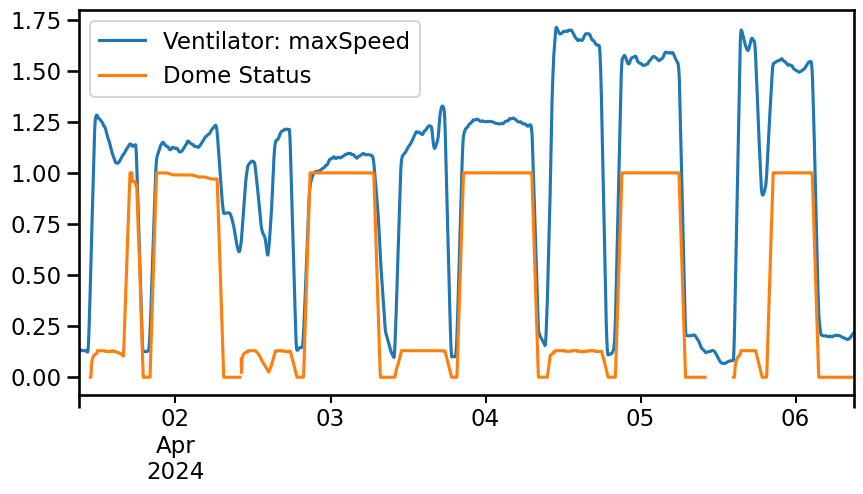

In [474]:
plt.figure(figsize=(10,5))
ax = efd.maxSpeed.rolling(window='1h').mean().plot(label='Ventilator: maxSpeed')
efd.mainDoorOpeningPercentage.rolling(window='1h').mean().plot(ax=ax, label='Dome Status')
plt.legend()

In [260]:
def get_night_start_time(df, fracTh=95):
    """Get the time when the dome was opened
    in a time window of 6pm to 10pm local time
    """
    # Step 1: Filter the dataframe to the time window between 18:00 to 00:00
    time_window_df = df.between_time('18:00', '01:00')
    
    # Step 2: Find the first occurrence where mainDoorOpeningPercentage >= 95%
    first_open_time = time_window_df.index[time_window_df['mainDoorOpeningPercentage'] >= fracTh].min()
    return first_open_time

t0 = get_night_start_time(df2, fracTh=.95)

In [372]:
def compute_vent_time_fraction(df, tend="23:00", th=0.6):
    # Assuming 'ts' is your time series DataFrame and 'threshold' is the threshold value
    ts = df.maxSpeed.rolling(window='20min').mean().between_time('12:00', tend)
    # t0.strftime('%H:%M')
    
    # Step 1: Create boolean masks indicating where the time series values are below and above the threshold
    below_threshold = ts < th
    above_threshold = ts >= th
    
    # Step 2: Identify the transition points where the time series crosses the threshold from below and from above
    transition_below = below_threshold.astype(int).diff()
    transition_above = above_threshold.astype(int).diff()
    
    # Step 3: Find the pairs of points where the time series crosses from below to above and then from above to below
    start_points = list(transition_below[transition_below == -1].index)
    end_points = list(transition_above[transition_above == -1].index)

    if len(end_points)==0: end_points = [ts.index.max()]
    if len(start_points)==0: end_points = [ts.index.max()]
    if len(end_points)<len(start_points): end_points += [ts.index.max()]
        
    # Elapsed time 
    eps = [(end - start).total_seconds()/3600 for start, end in zip(start_points, end_points)]
    ttime = (ts.index.max() - ts.index.min()).total_seconds()/3600
    
    # time fraction 
    timeFrac = np.sum(eps)/ttime
    nopeningns = len(eps)
    print(start_points)
    print(end_points)
    
    return timeFrac, nopeningns
    

In [360]:
timeFrac

0.9461305007587255

In [361]:
eps

[10.391666666666667]

In [362]:
import numpy as np
np.sum(eps)/ttime

0.9461305007587255

In [243]:
end_points

DatetimeIndex(['2024-04-02 15:19:30+00:00', '2024-04-02 20:40:30+00:00'], dtype='datetime64[ns, UTC]', freq=None)

In [227]:
eps = [(pair[1]-pair[0]).total_seconds()/3600 for pair in start_end_pairs]
eps

[2.2083333333333335, 7.558333333333334, 3.283333333333333]

In [214]:
start_end_pairs

[(Timestamp('2024-04-02 13:07:00+0000', tz='UTC'),
  Timestamp('2024-04-02 15:19:30+0000', tz='UTC')),
 (Timestamp('2024-04-02 13:07:00+0000', tz='UTC'),
  Timestamp('2024-04-02 20:40:30+0000', tz='UTC')),
 (Timestamp('2024-04-02 17:23:30+0000', tz='UTC'),
  Timestamp('2024-04-02 20:40:30+0000', tz='UTC'))]

In [184]:
exceed_duration

maxSpeed
1   0 days 01:06:30
2   0 days 02:12:00
3   0 days 02:03:30
4   0 days 03:16:30
5   0 days 00:19:30
Name: maxSpeed, dtype: timedelta64[ns]

In [438]:
def query_m2_air_temp(day, path='lsst.sal.ESS.temperature'):
    """
    SELECT "temperatureItem1" as "Air", "temperatureItem2" as "Truss", "temperatureItem3" as "M2" 
           FROM "efd"."autogen"."lsst.sal.ESS.temperature" WHERE salIndex = 201 AND "sensorName" = 'AuxTel-ESS01' 
           AND time > :dashboardTime: AND time < :upperDashboardTime:

    There are three auxtel sensor names:
    'AuxTel-ESS01', 'AuxTel-ESS02', 'AuxTel-ESS03'
    """
    cindex = ['salIndex','sensorName']
    columns = ['temperatureItem%i'%i for i in range(6)]
    df = getEfdData(client, path, columns=cindex+columns, dayObs=day, warn=False)

    # m2, air, truss
    mask = (df.salIndex==201) & (df.sensorName == 'AuxTel-ESS01')
    tempM2Air = df[columns].loc[mask].copy()
    column_mapping = {'temperatureItem1': 'Air', 'temperatureItem2': 'Truss','temperatureItem3': 'M2'}
    tempM2AirTruss = tempM2Air.rename(columns=column_mapping)
    tempM2AirTruss = tempM2AirTruss.drop(columns=['temperatureItem0','temperatureItem4','temperatureItem5'])
    return tempM2AirTruss.resample('30s').mean()


def query_m1_temp(day, path='lsst.sal.ESS.temperature'):
    """
    From chronograph: https://summit-lsp.lsst.codes/chronograf/sources/1/dashboards/91?
    
    SELECT "temperatureItem0" as "M1 sensor 1", "temperatureItem1" as "M1 sensor 2", "temperatureItem2" as "M1 sensor 3", 
           "temperatureItem3" as "M1 sensor 4", "temperatureItem4" as "M1 sensor 5", "temperatureItem5" as "M1 sensor 6" 
           FROM "efd"."autogen"."lsst.sal.ESS.temperature" 
           WHERE salIndex = 201 AND "sensorName" = 'AuxTel-ESS03' 
           AND time > :dashboardTime: AND time < :upperDashboardTime:

    There are three auxtel sensor names:
    'AuxTel-ESS01', 'AuxTel-ESS02', 'AuxTel-ESS03'
    
    """
    cindex = ['salIndex','sensorName']
    columns = ['temperatureItem%i'%i for i in range(6)]
    df = getEfdData(client, path, columns=cindex+columns, dayObs=day, warn=False)
    
    # get M1 temps
    mask = (df.salIndex==201) & (df.sensorName == 'AuxTel-ESS03')
    tempM1 = df[columns].loc[mask].copy()
    
    newcolumns = ['M1_sensor%i'%i for i in range(6)]
    column_mapping = {old_name: new_name for old_name, new_name in zip(columns, newcolumns)}
    tempM1 = tempM1.rename(columns=column_mapping)
    tempM1['M1'] = tempM1['M1_sensor4']
    return tempM1.resample('30s').mean()

def query_vent_speed(day, path="lsst.sal.ESS.airFlow"):
    """
    from chronograph: https://summit-lsp.lsst.codes/chronograf/sources/1/dashboards/168?
    
    SELECT mean("speed") AS "mean_speed" FROM "efd"."autogen"."lsst.sal.ESS.airFlow" 
           WHERE salIndex=204 AND time > :dashboardTime: AND time < :upperDashboardTime: 
           GROUP BY time(:interval:) FILL(null)
    interval = 720sec
    """
    cindex = ['salIndex','sensorName']
    columns = ['speed', 'maxSpeed', 'direction']
    df = getEfdData(client, path, columns=cindex+columns, dayObs=day, warn=False)
    mask = (df.salIndex==204)
    vent = df[columns].loc[mask].copy()
    vent.direction = vent.direction.fillna(-99)
    return vent.resample('720s').mean()


def query_sonic_temp(day, sensorName = 'ESS04',
                     path="lsst.sal.ESS.airTurbulence"):
    """
    From chronograph: https://summit-lsp.lsst.codes/chronograf/sources/1/dashboards/91?
    
    SELECT mean("sonicTemperature") AS "mean_sonicTemperature" FROM "efd"."autogen"."lsst.sal.ESS.airTurbulence" 
           WHERE time > :dashboardTime: AND time < :upperDashboardTime: AND salIndex = 201 
           GROUP BY time(:interval:) FILL(null)
    
    interval = 240sec

    There are two sensor names: 'AuxTel-ESS04' and 'AuxTel-GillLabJack01'
    """
    cindex = ['sensorName']
    columns = ['sonicTemperature', 'sonicTemperatureStdDev']
    df = getEfdData(client, path, columns=cindex+columns, dayObs=day, warn=False)
    if 'sensorName' in df.columns:
        mask = (df.sensorName == 'AuxTel-%s'%sensorName)
        sonic = df[columns].loc[mask].copy()
        sonic = sonic.resample('240s').mean()
    else:
        sonic = df
    return sonic

In [442]:
day = '20231106'
vals = []

def query_dome_pos(day,path='lsst.sal.ATDome.position'):
    columns = ['azimuthPosition', 'mainDoorOpeningPercentage']
    df = getEfdData(client, path, columns=columns, dayObs=day, warn=False)
    return df.resample('720s').mean()

vals.append(query_dome_pos(day))
vals.append(query_vent_speed(day))
vals.append(query_sonic_temp(day))
vals.append(query_m1_temp(day))
vals.append(query_m2_air_temp(day))
df2 = pd.concat(vals)
df2 = df2.sort_index().interpolate().resample('30s').mean()

In [443]:
df2

,azimuthPosition,mainDoorOpeningPercentage,speed,maxSpeed,direction,sonicTemperature,sonicTemperatureStdDev,M1_sensor0,M1_sensor1,M1_sensor2,M1_sensor3,M1_sensor4,M1_sensor5,M1,Air,Truss,M2
2023-11-06 12:00:00+00:00,NaN,NaN,0.063750,0.110833,-99.0,17.837118,0.062518,16.940604,16.288343,16.380547,13.994167,14.000490,14.208063,14.000490,15.030145,15.059280,16.174656
2023-11-06 12:00:30+00:00,NaN,NaN,0.063839,0.110578,-99.0,17.854415,0.064899,16.944096,16.293020,16.388942,13.995857,14.001781,14.208971,14.001781,15.021742,15.066216,16.184878
2023-11-06 12:01:00+00:00,NaN,NaN,0.063958,0.110238,-99.0,17.868253,0.066803,16.947936,16.300291,16.398993,13.996720,14.002953,14.209413,14.002953,15.008674,15.075617,16.201365
2023-11-06 12:01:30+00:00,NaN,NaN,0.064077,0.109898,-99.0,17.882091,0.068708,16.952030,16.309805,16.408620,13.995768,14.002223,14.208820,14.002223,14.989173,15.085264,16.213673
2023-11-06 12:02:00+00:00,NaN,NaN,0.064196,0.109558,-99.0,17.895928,0.070612,16.955544,16.322244,16.417326,13.996398,14.003108,14.209272,14.003108,14.976739,15.094752,16.224068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-07 11:57:30+00:00,102.688006,0.0,0.089583,0.171667,-99.0,16.034153,0.060461,16.263145,14.839179,14.876674,14.058917,14.072411,14.468147,14.072411,13.784447,13.611098,14.526022
2023-11-07 11:58:00+00:00,102.688006,0.0,0.089583,0.171667,-99.0,16.034153,0.060461,16.267427,14.843510,14.882398,14.058017,14.072302,14.467190,14.072302,13.769885,13.621067,14.535529
2023-11-07 11:58:30+00:00,102.688006,0.0,0.089583,0.171667,-99.0,16.034153,0.060461,16.273955,14.847735,14.890939,14.059271,14.070880,14.465917,14.070880,13.760369,13.628170,14.541099
2023-11-07 11:59:00+00:00,102.688006,0.0,0.089583,0.171667,-99.0,16.034153,0.060461,16.278157,14.836873,14.889022,14.058557,14.068557,14.464780,14.068557,13.749468,13.638100,14.549289


In [444]:
t0 = get_night_start_time(df2, fracTh=.95)

In [445]:
tf, no = compute_vent_time_fraction(df2, tend=t0.strftime("%H:%M"), th=0.6)
tf

ValueError: NaTType does not support strftime

In [430]:
def compute_vent_time_fraction2(df, t0="12:00", tend="23:00", th=0.6):
    ts = df.maxSpeed.rolling(window='5min').mean().between_time(t0, tend)
    above_threshold = ts >= th
    timeFrac = np.count_nonzero(above_threshold)/len(ts)
    return timeFrac

def compute_vent_sunset(df, tdome, timeDelta=2, th=0.6):
    tstart = tdome - pd.Timedelta(hours=timeDelta)
    t0 = tstart.strftime("%H:%M")
    tend = tdome.strftime("%H:%M")
    tfrac = compute_vent_time_fraction2(df, t0, tend, th)
    return tfrac>0.95
    

In [431]:
compute_vent_sunset(df2, t0, timeDelta=2)

0.11618257261410789


False

In [419]:
compute_vent_time_fraction2(df2, tend=t0.strftime("%H:%M"), th=0.6)

0.7415553809897879

In [420]:
t0 = get_night_start_time(df2, fracTh=.95)
t0

Timestamp('2024-04-03 22:36:00+0000', tz='UTC')

In [410]:
df2.mainDoorOpeningPercentage /= 100.

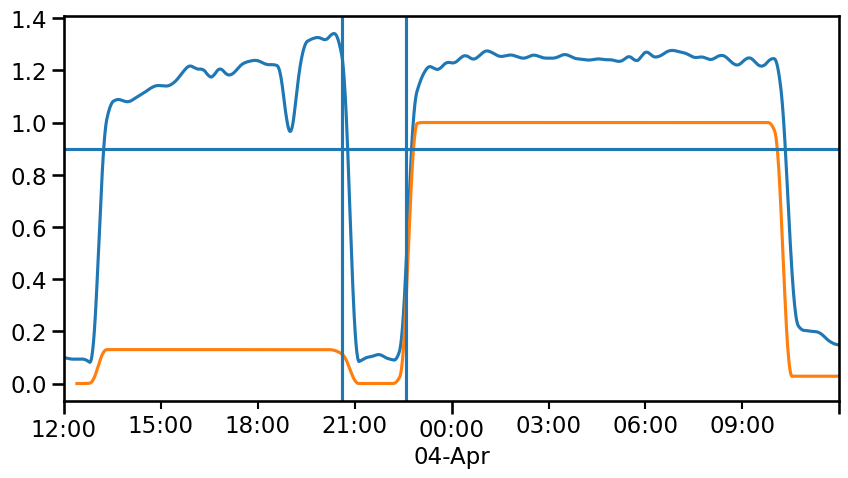

In [426]:
plt.figure(figsize=(10,5))
ax = df2.maxSpeed.rolling(window='20min').mean().plot()
df2.mainDoorOpeningPercentage.rolling(window='20min').mean().plot(ax=ax)
plt.axhline(0.9)
plt.axvline(t0)
plt.axvline(t0-pd.Timedelta(hours=2))

<Axes: >

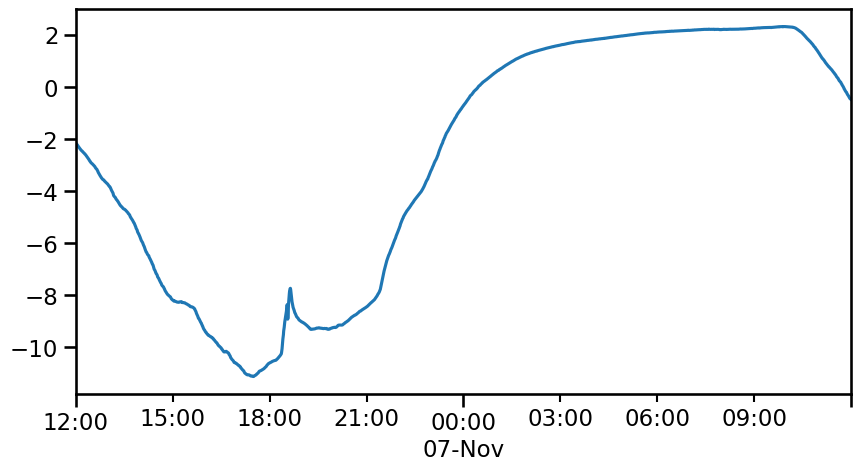

In [455]:
plt.figure(figsize=(10,5))
delta = df2.M1-df2.M2
delta.plot()

<Axes: >

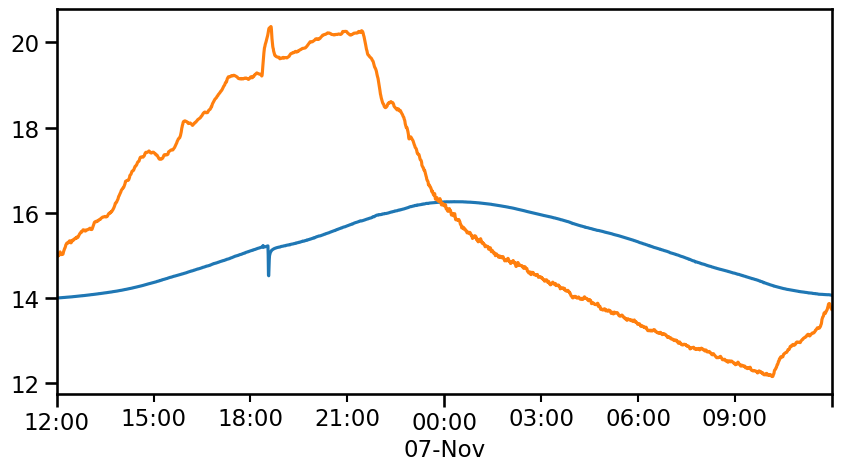

In [454]:
plt.figure(figsize=(10,5))
ax = df2.M1.plot()
df2.Air.plot(ax=ax)

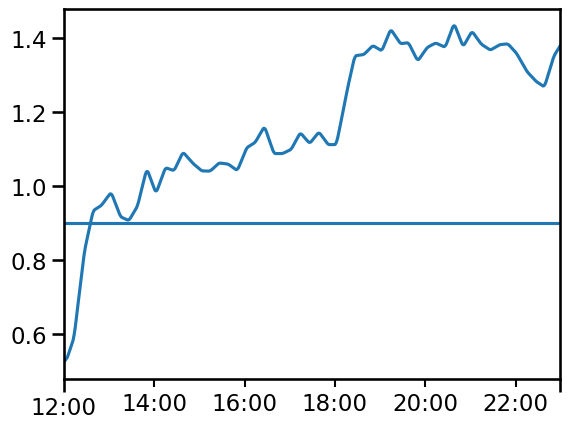

In [344]:
ts.plot()
plt.axhline(0.9)

In [293]:
ts.loc[above_threshold]

2024-03-21 12:34:00+00:00    0.904144
2024-03-21 12:34:30+00:00    0.908681
2024-03-21 12:35:00+00:00    0.913218
2024-03-21 12:35:30+00:00    0.917755
2024-03-21 12:36:00+00:00    0.922847
                               ...   
2024-03-21 17:58:00+00:00    1.111667
2024-03-21 17:58:30+00:00    1.111667
2024-03-21 17:59:00+00:00    1.111667
2024-03-21 17:59:30+00:00    1.111667
2024-03-21 18:00:00+00:00    1.112369
Freq: 30S, Name: maxSpeed, Length: 653, dtype: float64

Text(0.5, 1.0, 'T1: ESS04,  T2: GillLabJack01')

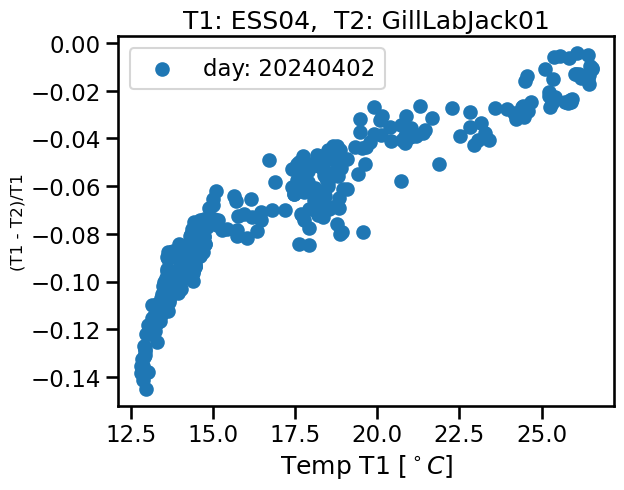

In [81]:
dT = (sonic.sonicTemperature - gill.sonicTemperature)/sonic.sonicTemperature
plt.scatter(sonic.sonicTemperature, dT, label='day: %s'%day)
plt.xlabel('Temp ESS04 [$^\circ C$]')
plt.title('Day: %s'%day)
plt.legend()
plt.ylabel('(T1 - T2)/T1',fontsize=12)
plt.xlabel('Temp T1 [$^\circ C$]')
plt.title('T1: ESS04,  T2: GillLabJack01')

Text(0.5, 1.0, 'T1: ESS04 and  T2: GillLabJack01')

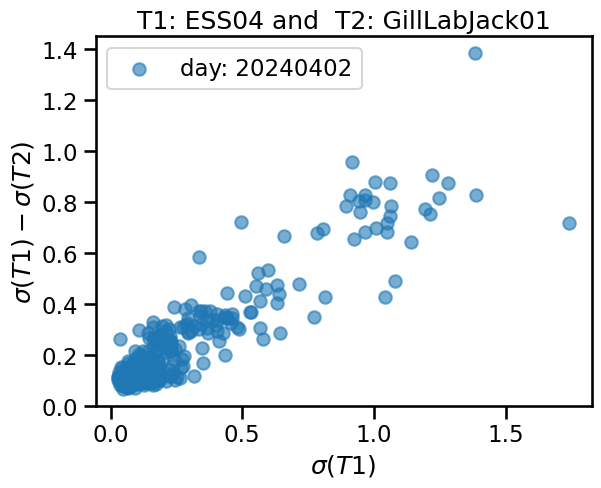

In [96]:
# dT = (sonic.sonicTemperatureStdDev - gill.sonicTemperatureStdDev)#/(sonic.sonicTemperatureStdDev+0.1)
plt.scatter(sonic.sonicTemperatureStdDev, gill.sonicTemperatureStdDev, label='day: %s'%day, alpha=0.6)
plt.title('Day: %s'%day)
plt.legend()
plt.ylabel('$\sigma(T1) - \sigma(T2)$',fontsize=18)
plt.xlabel('$\sigma(T1)$')
plt.title('T1: ESS04 and  T2: GillLabJack01')

In [ ]:
plt.figure(figsize=(10,5))
ax = vent.direction.rolling(window='20min').mean().plot()